In [0]:
%matplotlib inline
import torch
import torchvision
from torch.autograd import Variable
from torch.utils.data import TensorDataset,DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import time
import os
import torch.nn.init as init
import copy

### Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
trainPath = '/content/drive/My Drive/D/training/'
testPath = '/content/drive/My Drive/D/test/'

In [0]:
 trainPath1 ="/content/drive/My Drive/dataset1/train/"

Text(0.5, 1.0, 'Mask')

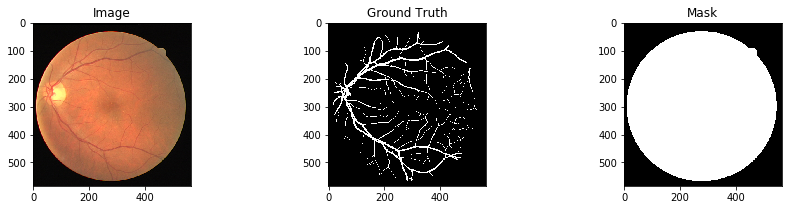

In [0]:
# Displaying sample image, groundtruth and mask from the dataset
sampleImg = np.array(Image.open(trainPath+'images/21_training.tif'))
sampleGT = np.array(Image.open(trainPath+'1st_manual/21_manual1.gif'))
sampleMask = np.array(Image.open(trainPath+'mask/21_training_mask.gif'))
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.imshow(sampleImg)
plt.title('Image')
plt.subplot(132)
plt.imshow(sampleGT,cmap='gray')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(sampleMask,cmap='gray')
plt.title('Mask')

In [0]:
sampleImg.shape[1]

565

In [0]:
# DRIVE dataset has 20 images for training and 20 for testing
TrainImages = torch.FloatTensor(1200,3,224,224)# 20 images x 30 patches
TrainLabels = torch.FloatTensor(1200,224,224)
TestImages = torch.FloatTensor(20,3,224,224)
TestLabels = torch.FloatTensor(20,224,224)

# Obtain list containing name of all files in the directoy
trainImgList = os.listdir(trainPath+'images')
testImgList = os.listdir(testPath+'images')

# Preparing train data tensors
img_no = 0
for file in trainImgList:
    imgNum = file.split('_')[0] # Image number from the filename
    im = Image.open(trainPath+'images/'+ file)
    seg = Image.open(trainPath+'1st_manual/'+str(imgNum)+'_manual1.gif')
    mask = Image.open(trainPath+'mask/'+str(imgNum)+'_training_mask.gif')
    im = np.array(im)
    seg = np.array(seg)/255
    mask = (np.array(mask)/255-seg)
    idx = np.where(mask==1)
    # Note: In the GT (seg), 0--> BG, 1--> Vessels, 2--> Tissue(mask)
    seg[idx] = 2
    
    # Augmenting training data by taking 30 patches, each of size 224x224, from the original image
    randIdx1 = np.random.randint(0,im.shape[0]-224,60) 
    randIdx2 = np.random.randint(0,im.shape[1]-224,60)
    for p in range(60):
        patch = im[randIdx1[p]:randIdx1[p]+224,randIdx2[p]:randIdx2[p]+224,:]/225
        seg_patch = seg[randIdx1[p]:randIdx1[p]+224,randIdx2[p]:randIdx2[p]+224]
        TrainImages[img_no] = torch.from_numpy(patch).transpose(0,2).unsqueeze(0)
        TrainLabels[img_no] = torch.from_numpy(seg_patch).transpose(0,1).unsqueeze(0)
        img_no += 1

# Preparing test data tensors
img_no = 0
for file in testImgList:
    imgNum = file.split('_')[0] # Image number from the filename
    im = Image.open(testPath+'images/'+ file)
    seg = Image.open(testPath+'1st_manual/'+str(imgNum)+'_manual1.gif')
    mask = Image.open(testPath+'mask/'+str(imgNum)+'_test_mask.gif')
    # Resizing the images to 224x224
    im = np.array(im.resize((224,224)))/255
    seg = np.array(seg.resize((224,224)))/255
    mask = (np.array(mask.resize((224,224)))-seg)/255
    idx = np.where(mask==1)
    # Note: In the GT (seg), 0--> BG, 1--> Vessels, 2--> Tissue(mask)
    seg[idx] = 2
    TestImages[img_no] = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
    TestLabels[img_no] = torch.from_numpy(seg).transpose(0,1).unsqueeze(0)
    img_no += 1

In [0]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([1200, 3, 224, 224])
torch.Size([1200, 224, 224])
torch.Size([20, 3, 224, 224])
torch.Size([20, 224, 224])


In [0]:
# Creating pytorch dataset
trainDataset = TensorDataset(TrainImages, TrainLabels)
testDataset = TensorDataset(TestImages, TestLabels)
# Creating dataloader
BatchSize = 20
trainLoader = DataLoader(trainDataset, batch_size=BatchSize, shuffle=True,num_workers=4, pin_memory=True)
testLoader = DataLoader(testDataset, batch_size=BatchSize, shuffle=False,num_workers=4, pin_memory=True)

In [0]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


## Defining network architecture

In [0]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()        
        
        # Encoder
        self.conv1c = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.conv2c = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.drp1 = nn.Dropout(p=0.3, inplace=False)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Decoder
       
        
        self.mup1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv21d = nn.Conv2d(64,32, kernel_size=3, stride=1, padding=1)
        self.relu51 = nn.ReLU()
        self.mup2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv1d = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        

    def forward(self, x):
        x = self.relu1(self.conv1c(x))
        x, idx2 = self.mp2(x) 
        x = self.relu2(self.conv2c(x))
        x = self.drp1(x)
        x, idx1 = self.mp1(x) 
        x = self.mup1(x, idx1)
        x = self.relu51(self.conv21d(x))
        x = self.mup2(x, idx2)
        x = self.conv1d(x)
        return x

## Initializing network

In [0]:
net = SegNet()
if use_gpu:
    net = net.cuda()

## Define loss function and optimizer

In [0]:
 
weights = [1,2,0.5] 
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(),  lr=0.001, betas=(0.7, 0.999), eps=1e-05, weight_decay=0, amsgrad=True)

## Train the network

At Iteration: 1 /50  ;  Training Loss: 0.040567; Time consumed: 0m 21s 
At Iteration: 1 /50  ;  Testing Loss: 0.024937 ; Time consumed: 0m 21s 
At Iteration: 2 /50  ;  Training Loss: 0.031674; Time consumed: 0m 21s 
At Iteration: 2 /50  ;  Testing Loss: 0.024011 ; Time consumed: 0m 21s 
At Iteration: 3 /50  ;  Training Loss: 0.031348; Time consumed: 0m 22s 
At Iteration: 3 /50  ;  Testing Loss: 0.023853 ; Time consumed: 0m 22s 
At Iteration: 4 /50  ;  Training Loss: 0.031123; Time consumed: 0m 22s 
At Iteration: 4 /50  ;  Testing Loss: 0.025799 ; Time consumed: 0m 22s 
At Iteration: 5 /50  ;  Training Loss: 0.030679; Time consumed: 0m 22s 
At Iteration: 5 /50  ;  Testing Loss: 0.022876 ; Time consumed: 0m 22s 
At Iteration: 6 /50  ;  Training Loss: 0.030367; Time consumed: 0m 22s 
At Iteration: 6 /50  ;  Testing Loss: 0.023511 ; Time consumed: 0m 22s 
At Iteration: 7 /50  ;  Training Loss: 0.030310; Time consumed: 0m 22s 
At Iteration: 7 /50  ;  Testing Loss: 0.023095 ; Time consumed: 

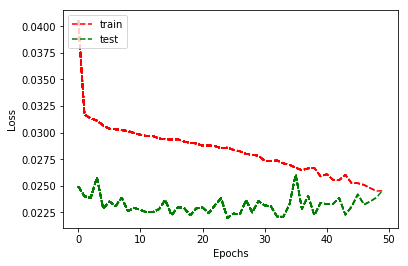

In [0]:
iterations = 50
trainLoss = []
testLoss = []
start = time.time()
#best_model_wts = copy.deepcopy(net.state_dict())
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0   
    net.train(True) # For training
    for data in trainLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.long().cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels.long())      
 
        
        # Feed-forward input data through the network
        outputs = net(inputs)
        # Compute loss/error
        loss = criterion(F.log_softmax(outputs,1), labels)
        # Initialize gradients to zero
        optimizer.zero_grad()                  
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.data          
    avgTrainLoss = runningLoss/1200    
    trainLoss.append(avgTrainLoss)
  
    
    # Evaluating performance on test set for each epoch
    net.train(False) # For testing
    test_runningLoss = 0    
    for data in testLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.long().cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels.long())         
        outputs = net(inputs)       
         # Compute loss/error
        loss = criterion(F.log_softmax(outputs,1), labels)      
        # Accumulate loss per batch
        test_runningLoss += loss.data 
        
    avgTestLoss = test_runningLoss/20  
    testLoss.append(avgTestLoss)
        
        
    # Plotting Loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r--',label='train')        
    plt.plot(range(epoch+1),testLoss,'g--',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')   
      
    
    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f}; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,epochEnd//60,epochEnd%60))
    print('At Iteration: {:.0f} /{:.0f}  ;  Testing Loss: {:.6f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTestLoss,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

In [0]:
torch.save(net.state_dict(),trainPath + 'modelSeg4' )

In [0]:
net.load_state_dict(torch.load(trainPath + 'modelSeg4'))
net.eval()

SegNet(
  (conv1c): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2c): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (drp1): Dropout(p=0.3)
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mup1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv21d): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu51): ReLU()
  (mup2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1d): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [0]:
TestImages.shape

torch.Size([20, 3, 224, 224])

In [0]:
# Visualizing segmentation on one of the test images
#randIdx = np.random.randint(20)
TestImages
testLab = TestLabels.numpy()
output_np = []
labels_np = []
for i in range(TestImages.shape[0]):
  segImg = net(Variable(TestImages[i]).unsqueeze(0).cuda())
  segImg_np = F.softmax(segImg,1) #.data.cpu().squeeze(0).numpy()
  output_np.append(segImg_np)#[1,:,:])
  
#bg = testLab==0
#vessel = testLab==1
#tissue = testLab==2

for i in range(TestLabels.shape[0]):
  testLabs=testLab[i]
  vessels = testLabs==1
  labels_np.append(vessels)
  #labels_np.

In [0]:
testoutput=torch.cat(output_np)
testoutput.shape

torch.Size([20, 3, 224, 224])

In [0]:
TO = torch.argmax(testoutput,1)
TO.view(-1).shape

torch.Size([1003520])

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as sm
a =sm.confusion_matrix(TO.cpu().view(-1),TestLabels.cpu().view(-1))
a

array([[304171,      6,    121],
       [   470,  70053,  89616],
       [  8869,  17826, 512388]])

In [0]:
from sklearn.preprocessing import label_binarize

In [0]:
y_test = TO.cpu().view(-1)
y_score = TestLabels.cpu().view(-1)

In [0]:
y = label_binarize(y_test, classes=[0, 1, 2])
y1 = label_binarize(y_score, classes=[0, 1, 2])

In [0]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

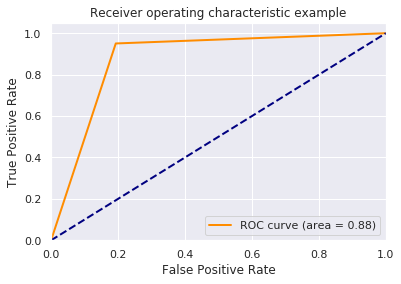

In [0]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
y_test

tensor([0, 0, 0,  ..., 0, 0, 0])

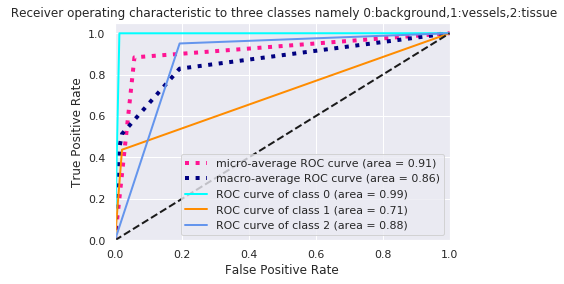

In [0]:
# Compute macro-average ROC curve and ROC area
import matplotlib.pyplot as plt
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Receiver operating characteristic to three classes namely 0:background,1:vessels,2:tissue')
plt.legend(loc="lower right")
plt.show()

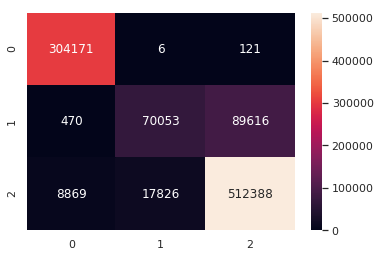

In [0]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
ax = sns.heatmap(a,annot=True, fmt="d")

In [0]:
sm.classification_report(TO.cpu().view(-1),TestLabels.cpu().view(-1))

'              precision    recall  f1-score   support\n\n           0       0.97      1.00      0.98    304298\n           1       0.80      0.44      0.56    160139\n           2       0.85      0.95      0.90    539083\n\n   micro avg       0.88      0.88      0.88   1003520\n   macro avg       0.87      0.80      0.82   1003520\nweighted avg       0.88      0.88      0.87   1003520\n'

In [0]:
sm.accuracy_score(TO.cpu().view(-1),TestLabels.cpu().view(-1))

0.8835020727040817